In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
def print_data(*data):
    for d in data:
        print(f'shape: {d.shape} | max: {np.max(d)} | min: {np.min(d)} | type: {d.dtype}')

In [9]:
def separate_data(numbers, x_data, y_data):
    return x_data[np.concatenate([np.where(y_data == n)[0] for n in numbers])]

In [ ]:
path = r'\Deep Learning\datasets\digits'
train_path = path + r'\train.csv'
test_path = path + r'\test.csv'

In [11]:
data_train = np.array(pd.read_csv(train_path)).astype('float32')
data_test = np.array(pd.read_csv(test_path)).astype('float32')

In [12]:
X_train = data_train[:, 1:] / 255.0
y_train = data_train[:, 0]

X_test = data_test / 255.0

In [13]:
new_data = separate_data([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], X_train, y_train)
np.random.shuffle(new_data)
X_train = new_data

In [14]:
print_data(new_data)

shape: (42000, 784) | max: 1.0 | min: 0.0 | type: float32


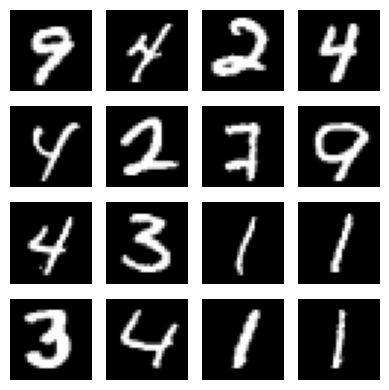

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for ax in axes.flat:
    img = new_data[np.random.randint(0, new_data.shape[0])].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [16]:
def ReLU(x, derv=False):
    if derv: return np.where(x>0, 1, 0)
    return np.maximum(x, 0)

In [17]:
def LeakyReLU(x, alpha=0.2, derv=False):
    if derv: return np.where(x>0, 1, alpha)
    return np.where(x>0, x, x*alpha)

In [18]:
def sigmoid(x, derv=False):
    s = 1 / (1 + np.exp(-x))
    if derv: return s * (1 - s)
    return s

In [19]:
def BCE(y, y_pred, epsilon=1e-8, derv=False):
    if derv: return -y/(y_pred+epsilon) + (1-y)/(1-y_pred+epsilon)
    return np.mean(-y*np.log(y_pred+epsilon) - (1-y)*np.log(1-y_pred+epsilon))

In [20]:
n_INPUTS = X_train.shape[1]
z_dim = 128
layers = 64
n_OUTPUTS = X_train.shape[1]

In [21]:
W0 = np.random.randn(n_INPUTS, layers).astype(np.float32) * np.sqrt(2/n_INPUTS)
b0 = np.zeros((1, layers))

Wmu = np.random.randn(layers, z_dim).astype(np.float32) * np.sqrt(2/layers)
Wlogvar = np.random.randn(layers, z_dim).astype(np.float32) * np.sqrt(2/layers)

bmu = np.zeros((1, z_dim))
blogvar = np.zeros((1, z_dim))

W1 = np.random.randn(z_dim, layers).astype(np.float32) * np.sqrt(2/z_dim)
b1 = np.zeros((1, layers))
W2 = np.random.randn(layers, n_OUTPUTS).astype(np.float32) * np.sqrt(2/layers)
b2 = np.zeros((1, n_OUTPUTS))

params = [W0, b0, Wmu, bmu, Wlogvar, blogvar, W1, b1, W2, b2]

In [22]:
num_grads = len(params)
m = [0] * num_grads
v = [0] * num_grads
t = 1
beta_1 = 0.9
beta_2 = 0.999
epsilon_adam = 1e-8

In [23]:
def optimizer_adam(grad, i):
    global t
    m[i] = beta_1 * m[i] + (1 - beta_1) * grad
    v[i] = beta_2 * v[i] + (1 - beta_2) * grad**2
    m_h = m[i] / (1 - beta_1**t)
    v_h = v[i] / (1 - beta_2**t)
    return m_h / (np.sqrt(v_h) + epsilon_adam)

In [24]:
def update_params(grads, lr):
    global t
    for i in range(num_grads):
        params[i] -= lr * optimizer_adam(grads[i], i)
    t += 1

In [25]:
def forward_encoder(x):
    global z0, a0, mue, logvare

    z0 = x @ W0 + b0
    a0 = LeakyReLU(z0)

    mue = a0 @ Wmu + bmu
    logvare = a0 @ Wlogvar + blogvar
    
    return mue, logvare

In [26]:
def forward_decoder(z):
    global z1, a1, z2, a2

    z1 = z @ W1 + b1
    a1 = ReLU(z1)

    z2 = a1 @ W2 + b2
    a2 = sigmoid(z2)
    
    return a2

In [27]:
def forward_VAE(x):
    global rand_sample, z, reconstruction
    mue, logvare = forward_encoder(x)
    rand_sample = np.random.standard_normal(size=mue.shape)
    z = mue + np.exp(logvare * 0.5) * rand_sample
    reconstruction = forward_decoder(z)
    return reconstruction, mue, logvare

In [28]:
def kl_div(mu, logvar, derv=False):
    if derv: return mu, -0.5 * (1 - np.exp(logvar))
    return -0.5 * np.mean(1 + logvar - np.power(mu, 2) - np.exp(logvar))

In [29]:
def backward_median(x, outp, learn=True, lr=0.0001):
    batch_size = x.shape[0]
    
    dL = BCE(x, outp, derv=True) / batch_size
    dL *= sigmoid(z2, derv=True)
    
    dW2 = a1.T @ dL
    db2 = dL.sum(axis=0, keepdims=True)
    
    da1 = dL @ W2.T
    dz1 = da1 * ReLU(z1, derv=True)
    
    dW1 = z.T @ dz1
    db1 = dz1.sum(axis=0, keepdims=True)
    
    dz = dz1 @ W1.T
    
    dlrelu = LeakyReLU(z0, derv=True)
    
    # MU

    dmu = dz
    
    dWmu = a0.T @ dmu
    dbmu = dmu.sum(axis=0, keepdims=True)
    
    da0mu = dmu @ Wmu.T
    dz0mu = da0mu * dlrelu
    
    dW0mu = x.T @ dz0mu
    db0mu = dz0mu.sum(axis=0, keepdims=True)
    
    # LOGVAR

    dlogvar = dz * np.exp(logvare * 0.5) * 0.5 * rand_sample
    
    dWlogvar = a0.T @ dlogvar
    dblogvar = dlogvar.sum(axis=0, keepdims=True)
    
    da0logvar = dlogvar @ Wlogvar.T
    dz0logvar = da0logvar * dlrelu
    
    dW0logvar = x.T @ dz0logvar
    db0logvar = dz0logvar.sum(axis=0, keepdims=True)
    
    # KL DIV

    dKL_mu, dKL_logvar = kl_div(mue, logvare, derv=True)
    dKL_mu /= batch_size
    dKL_logvar /= batch_size
    
    # KL MU

    dKL_Wmu = a0.T @ dKL_mu
    dKL_bmu = dKL_mu.sum(axis=0, keepdims=True)
    
    dKL_a0mu = dKL_mu @ Wmu.T
    dKL_z0mu = dKL_a0mu * dlrelu
    
    dKL_W0mu = x.T @ dKL_z0mu
    dKL_b0mu = dKL_z0mu.sum(axis=0, keepdims=True)
    
    # KL LOGVAR

    dKL_Wlogvar = a0.T @ dKL_logvar
    dKL_blogvar = dKL_logvar.sum(axis=0, keepdims=True)
    
    dKL_a0logvar = dKL_logvar @ Wlogvar.T
    dKL_z0logvar = dKL_a0logvar * dlrelu
    
    dKL_W0logvar = x.T @ dKL_z0logvar
    dKL_b0logvar = dKL_z0logvar.sum(axis=0, keepdims=True)
    
    dW0 = dW0mu + dW0logvar + dKL_W0mu + dKL_W0logvar
    db0 = db0mu + db0logvar + dKL_b0mu + dKL_b0logvar
    
    dWmu += dKL_Wmu
    dbmu += dKL_bmu
    dWlogvar += dKL_Wlogvar
    dblogvar += dKL_blogvar
    
    grads = (dW0, db0, dWmu, dbmu, dWlogvar, dblogvar, dW1, db1, dW2, db2)
    
    if learn:
        update_params(grads, lr)
    
    return None, grads

In [30]:
def train(x, epochs=10, batch_size=32, lr=0.001, print_every=0.1):
    for epoch in range(1, epochs+1):
        # np.random.shuffle(x)
        for batch in range(0, x.shape[0], batch_size):
            x_batch = x[batch:batch+batch_size]
            reconstruction, mue, logvare = forward_VAE(x_batch)
            backward_median(x=x_batch, outp=reconstruction, learn=True, lr=lr)
        
        if epoch % max(1, int(epochs*print_every)) == 0:
            reconstruction, mue, logvare = forward_VAE(x)
            KL_loss = kl_div(mue, logvare)
            loss = BCE(x, reconstruction)
            total_loss = loss + KL_loss
            print(f'Epoch: [{epoch}/{epochs}] Loss: {total_loss:.4f} | KL_loss: {KL_loss:.4f}')

In [31]:
train(
    x=X_train,
    epochs=10,
    batch_size=32,
    lr=0.0001,
    print_every=0.1
)

Epoch: [1/10] Loss: 0.4292 | KL_loss: 0.1411
Epoch: [2/10] Loss: 0.3671 | KL_loss: 0.1115
Epoch: [3/10] Loss: 0.3483 | KL_loss: 0.1216
Epoch: [4/10] Loss: 0.3359 | KL_loss: 0.1279
Epoch: [5/10] Loss: 0.3233 | KL_loss: 0.1249
Epoch: [6/10] Loss: 0.3199 | KL_loss: 0.1283
Epoch: [7/10] Loss: 0.3149 | KL_loss: 0.1284
Epoch: [8/10] Loss: 0.3136 | KL_loss: 0.1320
Epoch: [9/10] Loss: 0.3115 | KL_loss: 0.1337
Epoch: [10/10] Loss: 0.3133 | KL_loss: 0.1397


In [32]:
rand_image = X_test[np.random.randint(0, X_test.shape[0])]

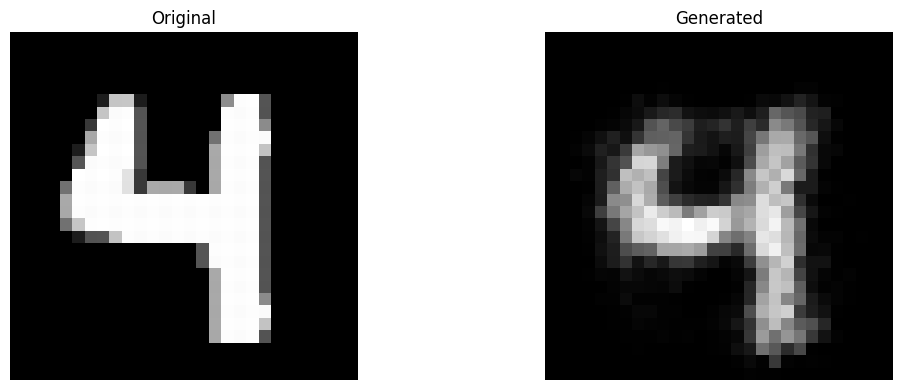

In [39]:
reconstruction= forward_VAE(rand_image)[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(rand_image.reshape(28, 28), cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(reconstruction.reshape(28, 28), cmap='gray')
axes[1].set_title("Generated")
axes[1].axis('off')

plt.tight_layout()
plt.show()